In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb
from trim_duplicates import DuplicatesData
import matplotlib.pyplot as plt

assert jax.local_device_count() >= 8

NUM_CLASSES = 4
SEED = 14
BATCH_SIZE = 128

def basemodel_process(x): return x

In [2]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("data/mendeley", rng=rng, official_split=False)
dataset_tawsifur = Dataset.load("data/tawsifur", rng=rng, official_split=False)
print("Loaded mendeley", dataset_mendeley.classnames)
print("Loaded tawsifur", dataset_tawsifur.classnames)

Loaded mendeley ['Normal', 'Viral pneumonia', 'COVID-19', 'Bacterial pneumonia']
Loaded tawsifur ['Normal', 'Viral pneumonia', 'COVID-19', 'Lung opacity']


Total embed dups: 6586
Total pix dups: 6580
Complement of difference: 24
1227 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1504).jpg
8107 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (2533).jpg
2976 data/mendeley/Normal/Normal (1666).jpg
3211 data/mendeley/Viral pneumonia/Pneumonia-Viral (1268).jpg
2004 data/mendeley/COVID-19/COVID-19 (215).jpg
6865 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (950).jpg
4856 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (300).jpg
9018 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1571).jpg


<Figure size 432x288 with 0 Axes>

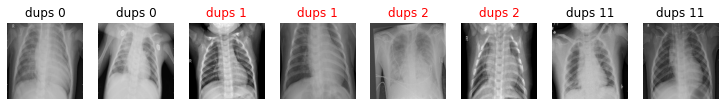

https://symbolize.stripped_domain/r/?trace=7fcf9a3515ce,7fcf9a27520f&map= 
*** SIGTERM received by PID 439359 (TID 439359) on cpu 90 from PID 442648; stack trace: ***
PC: @     0x7fcf9a3515ce  (unknown)  epoll_wait
    @     0x7fcd47b871e0        976  (unknown)
    @     0x7fcf9a275210  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7fcf9a3515ce,7fcd47b871df,7fcf9a27520f&map=ca1b7ab241ee28147b3d590cadb5dc1b:7fcd3ae88000-7fcd47ebab20 
E0106 21:45:44.012343  439359 coredump_hook.cc:250] RAW: Remote crash gathering disabled for SIGTERM.


In [3]:
def show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/cv_" + actual_name + ".pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    print("Total embed dups:", len(dups.indices))
    print("Total pix dups:", len(dups_pix.indices))
    print("Complement of difference:", len(diff))
    
    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

show_diff(dataset_mendeley, "embed")

Total embed dups: 6587
Total pix dups: 6580
Complement of difference: 23
1227 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1504).jpg
8107 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (2533).jpg
4856 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (300).jpg
9018 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1571).jpg


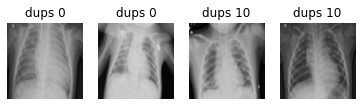

In [7]:
def custom_show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/" + actual_name + "_custom.pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    print("Total embed dups:", len(dups.indices))
    print("Total pix dups:", len(dups_pix.indices))
    print("Complement of difference:", len(diff))
    
    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

custom_show_diff(dataset_mendeley, "embed")

In [ ]:
dataset_mendeley.x_all.shape